# Open Science Survey Analytics (formatted)

This version standardizes table/plot formatting across cells while keeping the underlying data unchanged.


In [49]:
# Data manipulation
import pandas as pd
import numpy as np
import math
import re

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt

# Tools for cumulative operations
from functools import reduce

# Preferences
pd.set_option("display.max_columns", None)

from IPython.display import display
from pathlib import Path

# Plot defaults (kept minimal to avoid changing interpretation)
sns.set_theme(style="white")
plt.rcParams["figure.dpi"] = 110

pd.set_option("display.max_colwidth", 200)




## Load data (Google Colab)

Mount Drive and load the raw Qualtrics export + data dictionary.


In [50]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Research/Open Science/Data'

# Read in the data
raw_data = pd.read_csv("survey_data_anonymized.csv")
raw_data.columns = raw_data.iloc[0, :] # Replace col names with first row
raw_data = raw_data.iloc[2:, :].reset_index(drop=True) # Remove metadata rows

# Use data-dict to make cols easier to work with
data_dict = pd.read_csv("data_dictionary.csv")
df = raw_data.copy()
data_dict = dict(zip(data_dict['FullName'], data_dict['ShortName']))
df.columns = [data_dict.get(val) for val in list(df)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Research/Open Science/Data


## Clean and subset data

This keeps the raw data intact and creates a cleaned `df` and a plotting subset `plot_df`.


In [51]:
# CLEAN UP DF
df = df.dropna(subset=['pubs_authored'])
df['pubs_authored'] = df['pubs_authored'].astype(int)
df = df[df['pubs_authored']<200].reset_index(drop=True)

# Drop unnecessary cols
drop_cols = [
    'StartDate',
 'EndDate',
 'ResponseType',
 'Progress',
 'Duration',
 'Finished',
 'RecordedDate',
 'ResponseID',
 'DistributionChannel',
 'UserLanguage',
 'RecaptchaScore',
 'consent',
 'include_in_drawing'
]
plot_df = df.drop(drop_cols, axis=1)

## Helper functions

Reusable helpers for consistent tables, labels, and saved outputs.


In [52]:
# ---------------------------
# Helpers for consistent outputs
# ---------------------------

DEFAULT_DECIMALS = 2
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

def add_pct_n(df_out, n_col="n", N_col="N", pct_col="percent", decimals=DEFAULT_DECIMALS, out_col="pct (n/N)"):
    """Add a single, consistent column like: 12.34% (n=7/57)."""
    if N_col not in df_out.columns:
        return df_out
    N = df_out[N_col].iloc[0] if len(df_out) else None
    def _fmt(row):
        if N in [None, 0] or pd.isna(row.get(n_col)):
            return "–"
        pct = row.get(pct_col)
        n = int(row.get(n_col))
        return f"{pct:.{decimals}f}% (n={n}/{int(N)})"
    df_out[out_col] = df_out.apply(_fmt, axis=1)
    return df_out

def value_counts_table(df_in, col, *, dropna=True, decimals=DEFAULT_DECIMALS, sort_by="n", ascending=False):
    """Single-choice frequency table with n, percent, and N."""
    s = df_in[col]
    counts = s.value_counts(dropna=dropna)
    N = int(counts.sum())
    out = counts.rename("n").reset_index().rename(columns={"index":"option"})
    out["percent"] = (out["n"] / N * 100).round(decimals) if N else 0.0
    out["N"] = N
    if sort_by in out.columns:
        out = out.sort_values(sort_by, ascending=ascending)
    return out[["option","n","percent","N"]]

def binned_numeric_table(df_in, col, bins, labels, decimals=DEFAULT_DECIMALS):
    """Binned frequency table with option, n, percent, N."""
    if col not in df_in.columns:
        return pd.DataFrame(columns=["option", "n", "percent", "N"])

    s = pd.to_numeric(df_in[col], errors="coerce").dropna()
    N = int(len(s))
    if N == 0:
        return pd.DataFrame(columns=["option", "n", "percent", "N"])

    binned = pd.cut(s, bins=bins, labels=labels, include_lowest=True, right=True)
    counts = binned.value_counts(sort=False).rename("n").reset_index()
    counts = counts.rename(columns={counts.columns[0]: "option"})
    counts["percent"] = (counts["n"] / N * 100).round(decimals)
    counts["N"] = N
    return counts[["option", "n", "percent", "N"]]

def display_table(df_out, title=None, max_rows=None):
    if title:
        print(title)
    if max_rows is not None:
        display(df_out.head(max_rows))
    else:
        display(df_out)

def plot_bar_counts(df_in, col, xlabel, *, figsize=(8,4), save_name=None):
    temp = df_in[col].value_counts(dropna=True).reset_index()
    temp.columns = [col, "count"]
    # Consistent label wrapping
    temp[col] = (temp[col].astype(str)
                      .str.replace(r"\(Please Explain\)", "", regex=True)
                      .str.title()
                      .str.replace("Scientist-Practitioner", "Scientist-\nPractitioner")
                      .str.replace(" ", "\n")
                      .str.replace("-", "\n"))
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=temp, x=col, y="count", color="k", ax=ax)
    ax.set_ylabel("Number of Respondents", fontsize=18, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=18, labelpad=12)
    sns.despine(ax=ax, top=True, right=True)
    plt.tight_layout()
    if save_name:
        plt.savefig(OUTPUT_DIR / save_name, dpi=300, bbox_inches="tight")
    plt.show()
    return temp

def to_long_numeric(df_in, cols, rename_map=None, value_name="value"):
    temp = df_in[cols].copy()
    if rename_map:
        temp = temp.rename(columns=rename_map)
    temp = temp.melt(var_name="variable", value_name=value_name).dropna().reset_index(drop=True)
    temp[value_name] = pd.to_numeric(temp[value_name], errors="coerce")
    temp = temp.dropna(subset=[value_name]).reset_index(drop=True)
    temp[value_name] = temp[value_name].astype(int)
    return temp


## Demographics plots

All demographic bar charts use the same helper for consistent labels and figure settings.


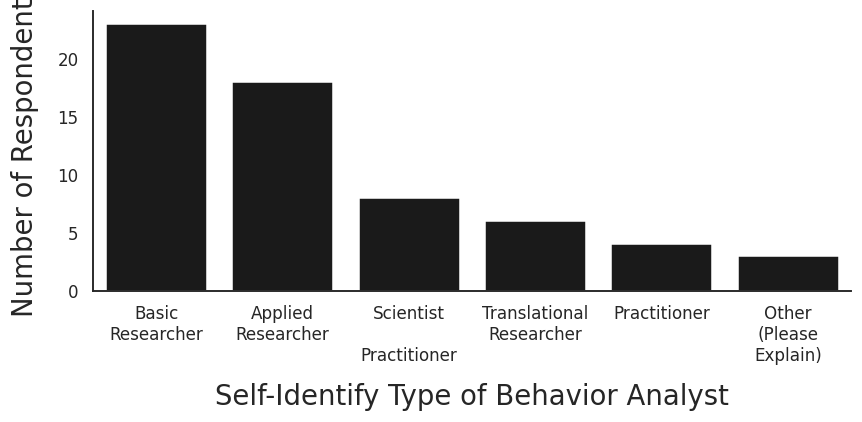

,ba_identify,count
0,Basic\nResearcher,23
1,Applied\nResearcher,18
2,Scientist\n\nPractitioner,8
3,Translational\nResearcher,6
4,Practitioner\n,4
5,Other\n(Please\nExplain),3


In [53]:
plot_bar_counts(plot_df, col='ba_identify', xlabel='Self-Identify Type of Behavior Analyst', save_name='demographics_ba_identify.png')


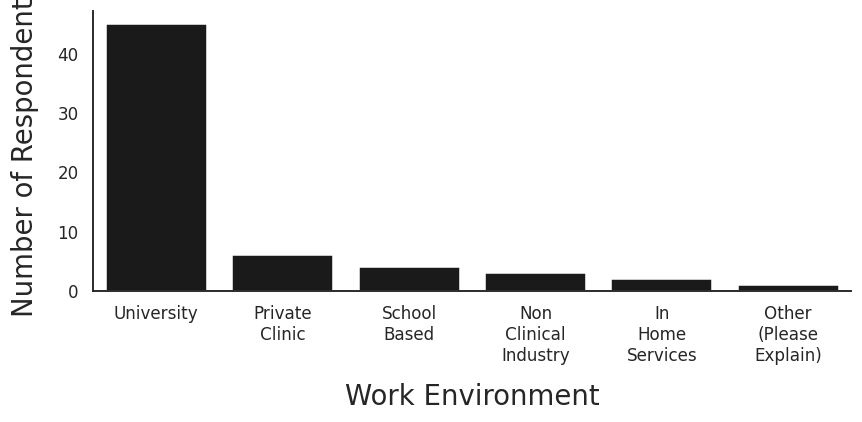

,primary_work_setting,count
0,University,45
1,Private\nClinic,6
2,School\nBased,4
3,Non\nClinical\nIndustry,3
4,In\nHome\nServices,2
5,Other\n(Please\nExplain),1


In [54]:
plot_bar_counts(plot_df, col='primary_work_setting', xlabel='Work Environment', save_name='demographics_work_environment.png')


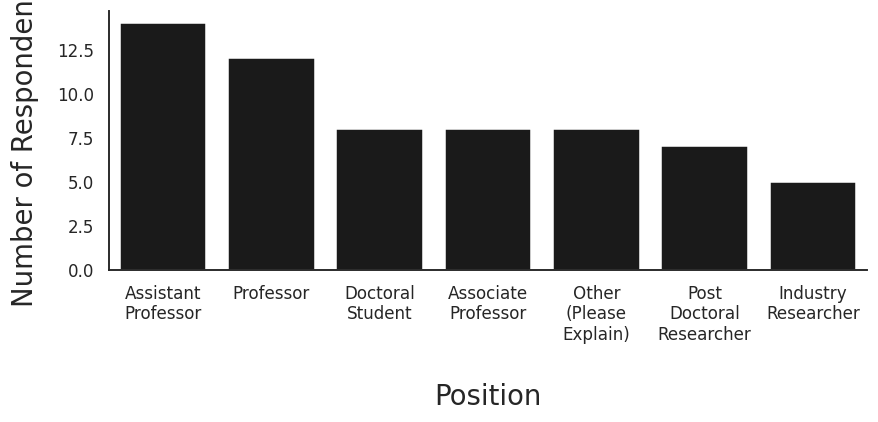

,current_position,count
0,Assistant\nProfessor\n,14
1,Professor,12
2,Doctoral\nStudent\n,8
3,Associate\nProfessor,8
4,Other\n(Please\nExplain),8
5,Post\nDoctoral\nResearcher\n,7
6,Industry\nResearcher,5


In [55]:
plot_bar_counts(plot_df, col='current_position', xlabel='Position', save_name='demographics_position.png')


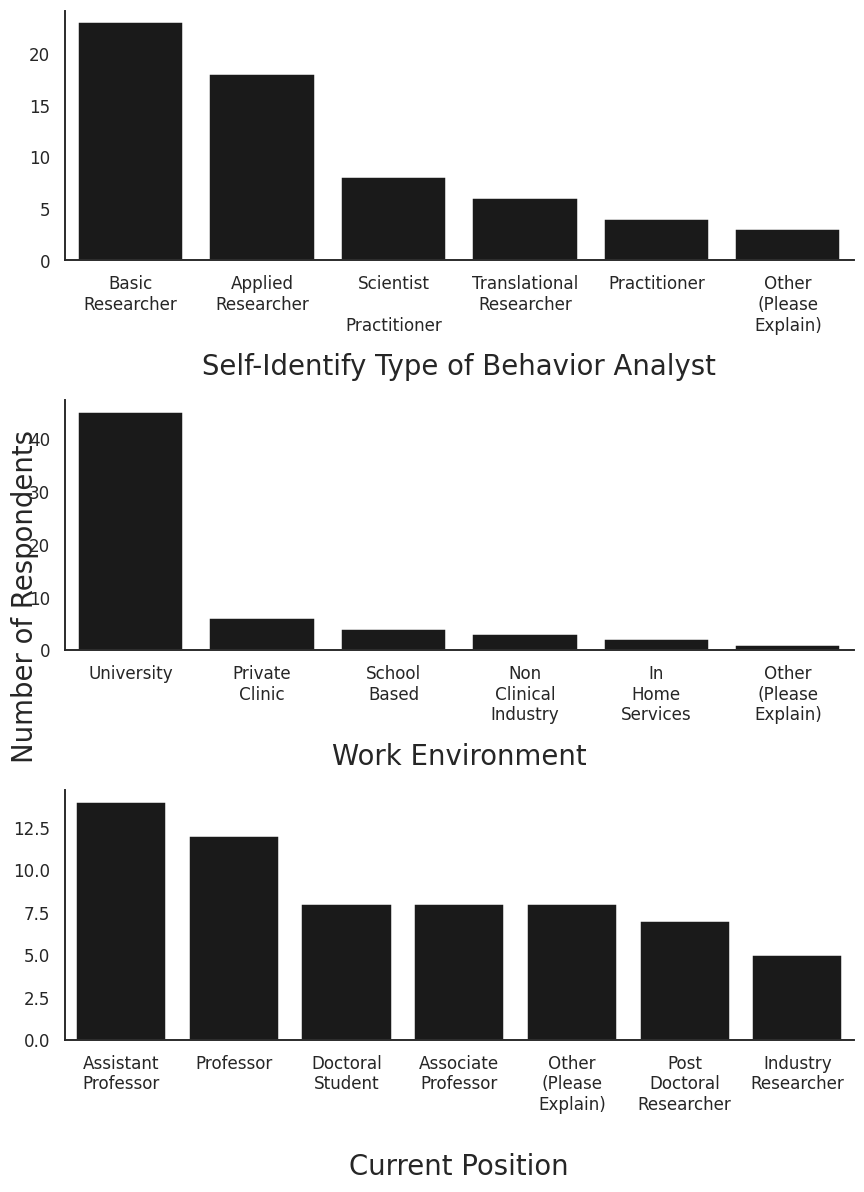

In [56]:
# Combined demographics figure (1 column × 3 rows)
columns = [
    ('ba_identify', 'Self-Identify Type of Behavior Analyst'),
    ('primary_work_setting', 'Work Environment'),
    ('current_position', 'Current Position')
]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 11))
fig.subplots_adjust(hspace=0.6)

for ax, (col_val, xlabel) in zip(axes, columns):
    temp = plot_df[col_val].value_counts(dropna=True).reset_index()
    temp.columns = [col_val, "count"]
    temp[col_val] = (temp[col_val].astype(str)
                           .str.replace(r"\(Please Explain\)", "", regex=True)
                           .str.title()
                           .str.replace("Scientist-Practitioner", "Scientist-\nPractitioner")
                           .str.replace(" ", "\n")
                           .str.replace("-", "\n"))
    sns.barplot(data=temp, x=col_val, y="count", color="k", ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel(xlabel, fontsize=18, labelpad=12)
    sns.despine(ax=ax, top=True, right=True)

fig.text(0.02, 0.5, "Number of Respondents", va="center", rotation="vertical", fontsize=18)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "demographics_panel.png", dpi=300, bbox_inches="tight")
plt.show()


## Perceptions, familiarity, and barriers

These plots use consistent long-format preparation and shared axis label conventions.


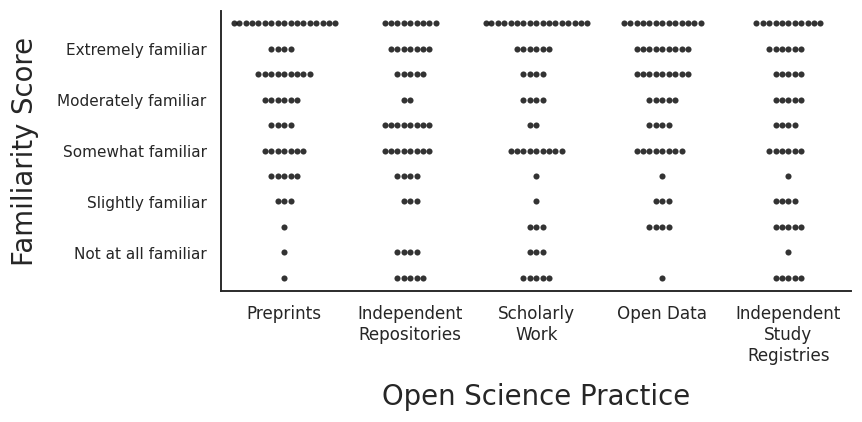

In [57]:
# Familiarity with OS practices (numeric scale)
familiar_cols = [c for c in plot_df.columns if "familiar" in c]

# Keep label order aligned with the data dictionary order used previously
familiar_labels = {
    "familiarity_preprint": "Preprints",
    "familiarity_ind_repo": "Independent\nRepositories",
    "familiarity_scholarly_work": "Scholarly\nWork",
    "familiarity_open_data": "Open Data",
    "familiarity_inde_study_registry": "Independent\nStudy\nRegistries",
}
rename_map = {c: familiar_labels.get(c, c) for c in familiar_cols}

temp_df = to_long_numeric(plot_df, familiar_cols, rename_map=rename_map)

fig, ax = plt.subplots(figsize=(8, 4))
sns.swarmplot(data=temp_df, x="variable", y="value", color="black", alpha=0.8, size=4, ax=ax)

ax.set_ylabel("Familiarity Score", fontsize=18, labelpad=12)
ax.set_xlabel("Open Science Practice", fontsize=18, labelpad=12)
ax.set_yticks([1, 3, 5, 7, 9])
ax.set_yticklabels(
    ["Not at all familiar", "Slightly familiar", "Somewhat familiar", "Moderately familiar", "Extremely familiar"],
    fontsize=10
)
sns.despine(ax=ax, top=True, right=True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "familiarity.png", dpi=300, bbox_inches="tight")
plt.show()


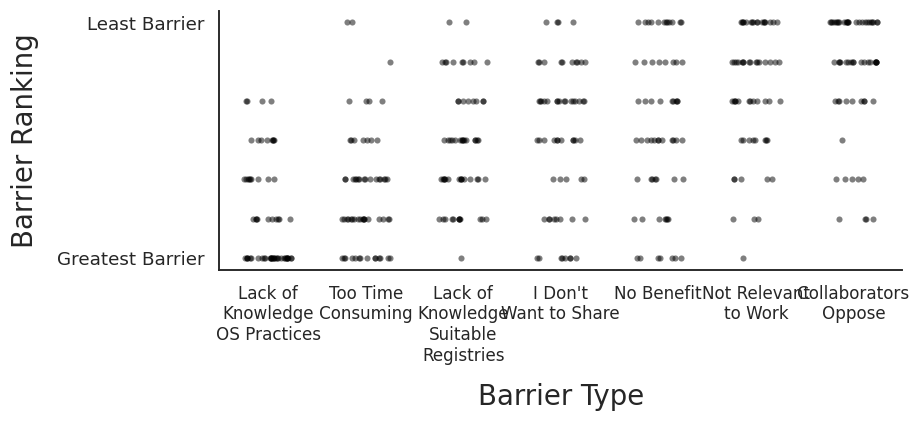

In [58]:
# Barrier rankings (1 = Greatest Barrier, 7 = Least Barrier)
barrier_cols = [c for c in plot_df.columns if c.startswith("barrier_")]

barrier_labels = {
    "barrier_knowledge_os_practices": "Lack of\nKnowledge\nOS Practices",
    "barrier_time_consuming_support": "Too Time\nConsuming",
    "barrier_researchers_no_share": "I Don't\nWant to Share",
    "barrier_knowledge_registries": "Lack of\nKnowledge\nSuitable\nRegistries",
    "barrier_not_relevant": "Not Relevant\nto Work",
    "barrier_collaborator_opposition": "Collaborators\nOppose",
    "barrier_no_benefit": "No Benefit",
}
rename_map = {c: barrier_labels.get(c, c) for c in barrier_cols}

temp_df = to_long_numeric(plot_df, barrier_cols, rename_map=rename_map)

# Reorder by mean (lowest mean = strongest barrier)
mean_order = temp_df.groupby("variable")["value"].mean().sort_values()
temp_df["variable"] = pd.Categorical(temp_df["variable"], categories=mean_order.index, ordered=True)

fig, ax = plt.subplots(figsize=(8.5, 4))

# Stripplot is less likely than swarmplot to produce placement warnings in dense data
sns.stripplot(data=temp_df, x="variable", y="value", color="black", alpha=0.5, size=4, jitter=0.25, ax=ax)

ax.set_ylabel("Barrier Ranking", fontsize=18, labelpad=12)
ax.set_xlabel("Barrier Type", fontsize=18, labelpad=12)
ax.set_yticks([1, 7])
ax.set_yticklabels(["Greatest Barrier", "Least Barrier"], fontsize=12)
sns.despine(ax=ax, top=True, right=True)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "barriers.png", dpi=300, bbox_inches="tight")
plt.show()


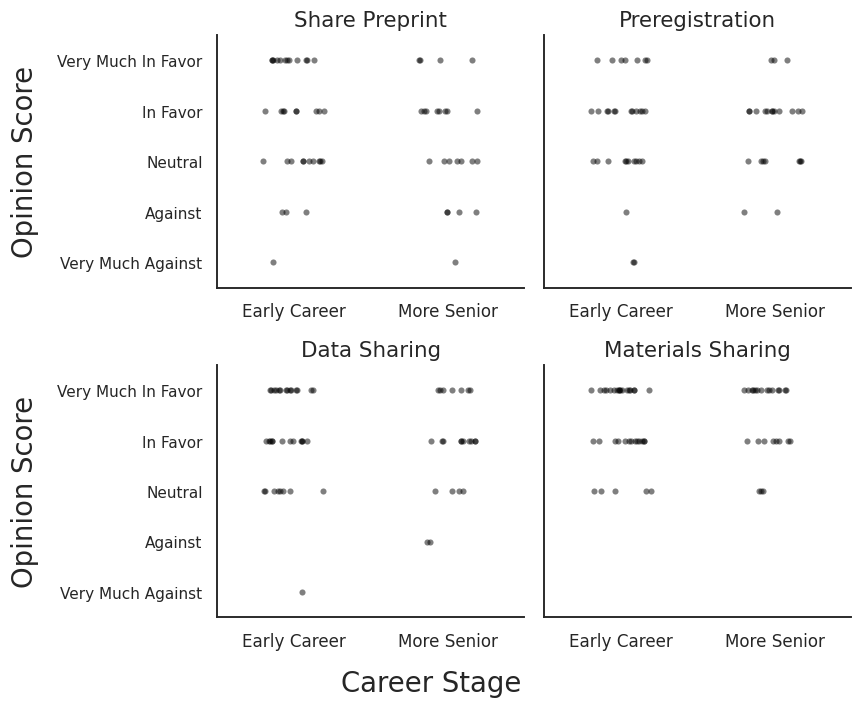

In [59]:
# Opinions about OS practices, split by career stage
opinion_cols = [c for c in plot_df.columns if "your_opinion" in c]
df_op = plot_df[opinion_cols + ["current_position"]].copy()

senior_career = ["Associate Professor", "Professor", "Industry Researcher"]
df_op["career_stage"] = np.where(df_op["current_position"].isin(senior_career), "More Senior", "Early Career")

practice_labels = {
    "your_opinion_share_preprint": "Share Preprint",
    "your_opinion_prereg": "Preregistration",
    "your_opinion_data_share": "Data Sharing",
    "your_opinion_share_materials": "Materials Sharing",
}
rename_map = {c: practice_labels.get(c, c) for c in opinion_cols}

df_long = df_op.rename(columns=rename_map).melt(
    id_vars=["career_stage"], value_vars=list(rename_map.values()),
    var_name="practice", value_name="opinion_text"
).dropna()

swap_dict = {
    "Very much in favor": 5,
    "In favor": 4,
    "Neither in favor nor against (i.e., neutral)": 3,
    "Against": 2,
    "Very much against": 1,
    "No opinion (i.e., I did not know anything about sharing data before this survey": -1,
}

df_long["opinion_score"] = df_long["opinion_text"].map(swap_dict)
df_long = df_long.dropna(subset=["opinion_score"]).reset_index(drop=True)
df_long["opinion_score"] = df_long["opinion_score"].astype(int)

no_opinion_counts = (df_long[df_long["opinion_score"] == -1]
                     .groupby("practice").size()
                     .rename("no_opinion_n")
                     .reset_index())

df_plot = df_long[df_long["opinion_score"].between(1, 5)].copy()

# Show counts of "No opinion" for context (kept consistent with later tables)
if len(no_opinion_counts):
    display_table(no_opinion_counts, title="No-opinion counts by practice (not included in the plot):")

# Plot: 2×2 grid, one practice per panel
practices = df_plot["practice"].unique()
rows, cols = 2, 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 6.5), sharey=True)
axes = axes.flatten()

for ax, practice in zip(axes, practices):
    subset = df_plot[df_plot["practice"] == practice]
    sns.stripplot(
        data=subset, x="career_stage", y="opinion_score",
        color="black", alpha=0.5, size=4, jitter=0.2, ax=ax
    )
    ax.set_title(practice, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Opinion Score", fontsize=18, labelpad=12)
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks([1,2,3,4,5])
    ax.set_yticklabels(["Very Much Against", "Against", "Neutral", "In Favor", "Very Much In Favor"], fontsize=10)
    sns.despine(ax=ax, top=True, right=True)

# Remove empty axes if fewer than 4 practices present
for i in range(len(practices), len(axes)):
    fig.delaxes(axes[i])

fig.text(0.5, 0.02, "Career Stage", ha="center", fontsize=18)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(OUTPUT_DIR / "opinion_by_career.png", dpi=300, bbox_inches="tight")
plt.show()


In [60]:
#export as CSV
df.to_csv('og_df.csv',index=False)

## Tables (standardized)

All tables below use consistent columns: `n`, `percent`, and the denominator `N` when applicable.


In [61]:
def value_counts_table(df_in, col, *, dropna=True, decimals=DEFAULT_DECIMALS, sort_by="n", ascending=False):
    """Single-choice frequency table with consistent columns: option, n, percent, N."""
    s = df_in[col]
    counts = s.value_counts(dropna=dropna)
    N = int(counts.sum())

    out = counts.rename("n").reset_index()

    # Robust rename: pandas usually names the first column after the original variable
    out = out.rename(columns={out.columns[0]: "option"})

    out["percent"] = (out["n"] / N * 100).round(decimals) if N else 0.0
    out["N"] = N

    if sort_by in out.columns:
        out = out.sort_values(sort_by, ascending=ascending)

    return out[["option", "n", "percent", "N"]]


In [62]:
# Distribution of specific numeric estimates (0–100) for "others' opinion" and "estimated peer practice"

def estimate_frequency_table(df_in, col, decimals=DEFAULT_DECIMALS):
    if col not in df_in.columns:
        return pd.DataFrame()
    s = pd.to_numeric(df_in[col], errors="coerce").dropna()
    N = int(len(s))
    if N == 0:
        return pd.DataFrame()
    out = s.value_counts().sort_index().rename("n").reset_index()
    out.columns = ["estimate_value", "n"]
    out["percent"] = (out["n"] / N * 100).round(decimals)
    out["question_name"] = col
    out["N"] = N
    return out[["question_name", "estimate_value", "n", "percent", "N"]]

# De-duplicate columns defensively (keeps data unchanged)
df_nodup = df.loc[:, ~df.columns.duplicated()].copy()

target_cols = [
    # Peer Opinion Distribution (20 columns)
    'others_opinion_sharing_preprints_vmuchagainst', 'others_opinion_sharing_preprints_against',
    'others_opinion_sharing_preprints_neutral', 'others_opinion_sharing_preprints_infavor',
    'others_opinion_sharing_preprints_vmuchinfavor',

    'others_opinion_use_prereg_vmuchagainst', 'others_opinion_use_prereg_against',
    'others_opinion_use_prereg_neutral', 'others_opinion_use_prereg_infavor',
    'others_opinion_use_prereg_vmuchinfavor',

    'others_opinion_use_ind_repo_vmuchagainst', 'others_opinion_use_ind_repo_against',
    'others_opinion_use_ind_repo_neutral', 'others_opinion_use_ind_repo_infavor',
    'others_opinion_use_ind_repo_vmuchinfavor',

    'others_opinion_use_share_materials_vmuchagainst', 'others_opinion_use_share_materials_against',
    'others_opinion_use_share_materials_neutral', 'others_opinion_use_share_materials_infavor',
    'others_opinion_use_share_materials_vmuchinfavor',

    # Peer Practice/Usage (4 columns)
    'est_percent_colleagues_share', 'est_percent_colleagues_prereg',
    'est_percent_colleagues_ind_repo', 'est_percent_colleagues_share_materials'
]

freq_df = pd.concat([estimate_frequency_table(df_nodup, col) for col in target_cols], ignore_index=True)

out_file = OUTPUT_DIR / "estimation_frequency_distribution.csv"
freq_df.to_csv(out_file, index=False)

display_table(freq_df.head(20), title="Preview: " + out_file.name)

# Quick check (example): 20% estimate for Preprints (In Favor)
check = freq_df[
    (freq_df["question_name"] == "others_opinion_sharing_preprints_infavor") &
    (freq_df["estimate_value"] == 20)
]
if len(check):
    display_table(check, title="Check: 20% estimate for preprints (in favor)")


Preview: estimation_frequency_distribution.csv


,question_name,estimate_value,n,percent,N
0,others_opinion_sharing_preprints_vmuchagainst,0.0,22,35.48,62
1,others_opinion_sharing_preprints_vmuchagainst,2.0,1,1.61,62
2,others_opinion_sharing_preprints_vmuchagainst,5.0,13,20.97,62
3,others_opinion_sharing_preprints_vmuchagainst,7.0,1,1.61,62
4,others_opinion_sharing_preprints_vmuchagainst,10.0,9,14.52,62
5,others_opinion_sharing_preprints_vmuchagainst,15.0,4,6.45,62
6,others_opinion_sharing_preprints_vmuchagainst,20.0,3,4.84,62
7,others_opinion_sharing_preprints_vmuchagainst,25.0,1,1.61,62
8,others_opinion_sharing_preprints_vmuchagainst,30.0,5,8.06,62
9,others_opinion_sharing_preprints_vmuchagainst,40.0,1,1.61,62


Check: 20% estimate for preprints (in favor)


,question_name,estimate_value,n,percent,N
44,others_opinion_sharing_preprints_infavor,20.0,18,29.03,62


In [63]:
# Complete frequency tables (including demographics) in a consistent format

target_columns = [
    # Knowledge & Experience
    'experience_os_practices', 'familiarity_preprint', 'familiarity_ind_repo',
    'familiarity_scholarly_work', 'familiarity_open_data', 'familiarity_inde_study_registry',

    # Opinions & Use
    'your_opinion_share_preprint', 'knowledge_preprints_ind_repo', 'pubs_ind_repo_preprint',
    'recent_pub_a_preprint', 'est_percent_colleagues_share', 'your_opinion_prereg',
    'knowledge_prereg', 'pubs_prereg', 'recent_pub_prereg', 'est_percent_colleagues_prereg',
    'your_opinion_data_share', 'knowledge_ind_repo', 'pubs_ind_repo_shared',
    'recent_pub_ind_repo', 'est_percent_colleagues_ind_repo', 'your_opinion_share_materials',
    'pubs_share_materials', 'how_share_materials', 'recent_pub_share_materials',

    # Barriers & Learning
    'barrier_knowledge_os_practices', 'barrier_time_consuming_support',
    'barrier_researchers_no_share', 'barrier_knowledge_registries',
    'barrier_not_relevant', 'barrier_collaborator_opposition', 'barrier_no_benefit',
    'increase_knowledge_include_grad_training', 'increase_knowledge_support_superiors',
    'rank_impact_include_grad_training', 'rank_impact_support_superiors',
    'sources_you_learned_from', 'how_like_learn_more',

    # Future Plans
    'plan_to_post_preprint', 'plan_to_read_preprint', 'plan_make_data_open',
    'plan_to_prereg', 'research_conducted',

    # --- DEMOGRAPHICS ADDED HERE ---
    'race',
    'gender',
    'ba_identify',
    'current_position',
    'primary_work_setting',
    'years_current_position'
]

df_subset = df[target_columns].copy()

tables = []
for col in df_subset.columns:
    t = value_counts_table(df_subset, col, dropna=True, decimals=DEFAULT_DECIMALS)
    t.insert(0, "question_name", col)
    tables.append(t)

# --- Publications authored (binned) ---
pub_bins   = [-0.1, 10, 25, 50, 100, 200]  # 200 captures 199 due to your <200 filter
pub_labels = ["0–10", "11–25", "26–50", "51–100", "101–199"]

t_pub = binned_numeric_table(df, "pubs_authored", bins=pub_bins, labels=pub_labels)
t_pub.insert(0, "question_name", "pubs_authored_binned")
tables.append(t_pub)

complete_df = pd.concat(tables, ignore_index=True)
complete_df = add_pct_n(complete_df, n_col="n", N_col="N", pct_col="percent")

out_file = OUTPUT_DIR / "complete_survey_results_with_demographics.csv"
complete_df.to_csv(out_file, index=False)

display_table(complete_df.head(25), title="Preview: " + out_file.name)


Preview: complete_survey_results_with_demographics.csv


,question_name,option,n,percent,N,pct (n/N)
0,experience_os_practices,I have some experience with open science practices,28,45.16,62,45.16% (n=28/62)
1,experience_os_practices,"I am aware of open science, but have not used open science practices in my research",20,32.26,62,32.26% (n=20/62)
2,experience_os_practices,I have extensive experience with open science practices,10,16.13,62,16.13% (n=10/62)
3,experience_os_practices,"Until now, I was unaware of open science practices",4,6.45,62,6.45% (n=4/62)
4,familiarity_preprint,10,17,29.31,58,29.31% (n=17/62)
5,familiarity_preprint,8,9,15.52,58,15.52% (n=9/62)
6,familiarity_preprint,5,7,12.07,58,12.07% (n=7/62)
7,familiarity_preprint,7,6,10.34,58,10.34% (n=6/62)
8,familiarity_preprint,4,5,8.62,58,8.62% (n=5/62)
9,familiarity_preprint,6,4,6.90,58,6.90% (n=4/62)


## Analytic tables

The following cells generate the paper tables (career-stage comparisons, engagement by researcher type, barriers, and learning preferences) with consistent `n`, `percent`, and `N` fields.


In [64]:
# ---- Career stage barriers (endorsement thresholds) ----
df_work = plot_df.copy()
POSITION_COL = "current_position"
BARRIER_PREFIX = "barrier_"
SENIOR_TITLES = {"Associate Professor", "Professor", "Industry Researcher"}

barrier_cols = [c for c in df_work.columns if c.startswith(BARRIER_PREFIX)]
for c in barrier_cols:
    df_work[c] = pd.to_numeric(df_work[c], errors="coerce")

df_work["career_stage"] = np.where(df_work[POSITION_COL].isin(SENIOR_TITLES), "Senior", "Early")

def get_barrier_stats(frame, barrier_col, stage_col="career_stage", rule="top2"):
    s = frame[[stage_col, barrier_col]].dropna()
    if rule == "top2":
        endorsed = s[barrier_col].isin([1, 2]).astype(int)
    elif rule == "top3":
        endorsed = s[barrier_col].isin([1, 2, 3]).astype(int)
    else:
        raise ValueError("rule must be 'top2' or 'top3'")
    out = (s.assign(endorsed=endorsed)
             .groupby(stage_col)["endorsed"]
             .agg(total_N="count", endorsed_n="sum")
             .reset_index())
    out["percent"] = (out["endorsed_n"] / out["total_N"] * 100).round(DEFAULT_DECIMALS)
    return out

def build_barrier_table(rule):
    rows = []
    for col in barrier_cols:
        pretty = (col.replace("barrier_", "")
                    .replace("_", " ")
                    .title()
                    .replace("Os", "OS"))
        t = get_barrier_stats(df_work, col, rule=rule)
        t["Barrier"] = pretty
        t["barrier_var"] = col
        rows.append(t)
    tab = pd.concat(rows, ignore_index=True)

    wide = tab.pivot(index=["Barrier","barrier_var"], columns="career_stage", values=["percent","total_N","endorsed_n"])
    wide.columns = [f"{metric}_{stage}" for metric, stage in wide.columns]
    wide = wide.reset_index()

    # Add consistent "pct (n/N)" columns for each stage
    for stage in ["Early", "Senior"]:
        wide[f"pct (n/N)_{stage}"] = wide.apply(
            lambda r: (
                f"{r.get('percent_'+stage, 0):.{DEFAULT_DECIMALS}f}% "
                f"(n={int(r.get('endorsed_n_'+stage, 0))}/{int(r.get('total_N_'+stage, 0))})"
            ) if pd.notna(r.get('total_N_'+stage)) and r.get('total_N_'+stage, 0) else "–",
            axis=1
        )

    # Clean + order columns
    col_order = [
        "Barrier","barrier_var",
        "endorsed_n_Early","total_N_Early","percent_Early","pct (n/N)_Early",
        "endorsed_n_Senior","total_N_Senior","percent_Senior","pct (n/N)_Senior",
    ]
    for col in col_order:
        if col not in wide.columns:
            wide[col] = pd.NA
    wide = wide[col_order].sort_values("Barrier").reset_index(drop=True)
    return wide

top2_table = build_barrier_table("top2")
top3_table = build_barrier_table("top3")

display_table(top2_table, title="Barrier endorsement (Top-2: Greatest Barrier) — Early vs Senior")
display_table(top3_table, title="Barrier endorsement (Top-3: Major Barrier) — Early vs Senior")


Barrier endorsement (Top-2: Greatest Barrier) — Early vs Senior


,Barrier,barrier_var,endorsed_n_Early,total_N_Early,percent_Early,pct (n/N)_Early,endorsed_n_Senior,total_N_Senior,percent_Senior,pct (n/N)_Senior
0,Collaborator Opposition,barrier_collaborator_opposition,2.0,37.0,5.41,5.41% (n=2/37),2.0,25.0,8.0,8.00% (n=2/25)
1,Knowledge OS Practices,barrier_knowledge_os_practices,24.0,37.0,64.86,64.86% (n=24/37),17.0,25.0,68.0,68.00% (n=17/25)
2,Knowledge Registries,barrier_knowledge_registries,7.0,37.0,18.92,18.92% (n=7/37),6.0,25.0,24.0,24.00% (n=6/25)
3,No Benefit,barrier_no_benefit,10.0,37.0,27.03,27.03% (n=10/37),4.0,25.0,16.0,16.00% (n=4/25)
4,Not Relevant,barrier_not_relevant,2.0,37.0,5.41,5.41% (n=2/37),2.0,25.0,8.0,8.00% (n=2/25)
5,Researchers No Share,barrier_researchers_no_share,12.0,37.0,32.43,32.43% (n=12/37),4.0,25.0,16.0,16.00% (n=4/25)
6,Time Consuming Support,barrier_time_consuming_support,17.0,37.0,45.95,45.95% (n=17/37),15.0,25.0,60.0,60.00% (n=15/25)


Barrier endorsement (Top-3: Major Barrier) — Early vs Senior


,Barrier,barrier_var,endorsed_n_Early,total_N_Early,percent_Early,pct (n/N)_Early,endorsed_n_Senior,total_N_Senior,percent_Senior,pct (n/N)_Senior
0,Collaborator Opposition,barrier_collaborator_opposition,7.0,37.0,18.92,18.92% (n=7/37),2.0,25.0,8.0,8.00% (n=2/25)
1,Knowledge OS Practices,barrier_knowledge_os_practices,31.0,37.0,83.78,83.78% (n=31/37),19.0,25.0,76.0,76.00% (n=19/25)
2,Knowledge Registries,barrier_knowledge_registries,13.0,37.0,35.14,35.14% (n=13/37),15.0,25.0,60.0,60.00% (n=15/25)
3,No Benefit,barrier_no_benefit,14.0,37.0,37.84,37.84% (n=14/37),7.0,25.0,28.0,28.00% (n=7/25)
4,Not Relevant,barrier_not_relevant,2.0,37.0,5.41,5.41% (n=2/37),7.0,25.0,28.0,28.00% (n=7/25)
5,Researchers No Share,barrier_researchers_no_share,15.0,37.0,40.54,40.54% (n=15/37),6.0,25.0,24.0,24.00% (n=6/25)
6,Time Consuming Support,barrier_time_consuming_support,29.0,37.0,78.38,78.38% (n=29/37),19.0,25.0,76.0,76.00% (n=19/25)


In [65]:
# ---------- Engagement (% + n) by researcher identity ----------
IDENTITY_COL = "ba_identify"
CAREER_STAGE_COL = "career_stage"  # may be present depending on earlier processing
ENGAGEMENT_COLS = {
    "Preregistration": "recent_pub_prereg",
    "Independent Repository": "recent_pub_ind_repo",
    "Preprint": "recent_pub_a_preprint",
    "Materials Sharing": "recent_pub_share_materials",
}

IDENTITY_SYNONYMS = {
    "basic researcher": {"basic", "basic researcher", "basic science"},
    "applied researcher": {"applied", "applied researcher"},
    "translational researcher": {"translational", "translational researcher"},
    "scientist-practitioner": {"scientist practitioner", "scientist-practitioner"},
    "practitioner": {"practitioner", "clinician"},
    "other": {"other", "na", "n/a", ""},
}

POSITIVE_USED = {"yes"}

def canonicalize(x):
    if pd.isna(x):
        return ""
    return str(x).strip().lower()

def map_identity(x):
    v = canonicalize(x)
    for canon, syns in IDENTITY_SYNONYMS.items():
        if v in {canonicalize(s) for s in syns}:
            return canon
    return x if v else "other"

def to_binary(val):
    if pd.isna(val):
        return 0
    v = canonicalize(val)
    if v in POSITIVE_USED:
        return 1
    if v.isdigit():
        return 1 if int(v) > 0 else 0
    return 0

_work = df.copy()
_work["_identity"] = _work[IDENTITY_COL].apply(map_identity).astype(str)

for label, col in ENGAGEMENT_COLS.items():
    _work[f"engaged_{label}"] = _work[col].apply(to_binary)

rows = []
for label in ENGAGEMENT_COLS.keys():
    tmp = (
        _work.groupby("_identity")[f"engaged_{label}"]
             .agg(engaged_n="sum", N="count")
             .reset_index()
    )
    tmp["percent"] = (tmp["engaged_n"] / tmp["N"] * 100).round(DEFAULT_DECIMALS)
    tmp["practice"] = label
    rows.append(tmp)

long = pd.concat(rows, ignore_index=True)

# Wide table with consistent "% (n/N)" strings per practice
wide = long.pivot(index="_identity", columns="practice", values=["engaged_n","N","percent"])
wide.columns = [f"{metric}__{practice}" for metric, practice in wide.columns]
wide = wide.reset_index()

for practice in ENGAGEMENT_COLS.keys():
    wide[f"pct (n/N)__{practice}"] = wide.apply(
        lambda r: (
            f"{r[f'percent__{practice}']:.{DEFAULT_DECIMALS}f}% "
            f"(n={int(r[f'engaged_n__{practice}'])}/{int(r[f'N__{practice}'])})"
        ),
        axis=1
    )

# Arrange columns
col_order = ["_identity"]
for practice in ENGAGEMENT_COLS.keys():
    col_order += [f"pct (n/N)__{practice}", f"engaged_n__{practice}", f"N__{practice}", f"percent__{practice}"]

wide = wide[col_order].sort_values("_identity").reset_index(drop=True)

display_table(wide, title="Engagement by researcher identity (consistent formatting)")


Engagement by researcher identity (consistent formatting)


,_identity,pct (n/N)__Preregistration,engaged_n__Preregistration,N__Preregistration,percent__Preregistration,pct (n/N)__Independent Repository,engaged_n__Independent Repository,N__Independent Repository,percent__Independent Repository,pct (n/N)__Preprint,engaged_n__Preprint,N__Preprint,percent__Preprint,pct (n/N)__Materials Sharing,engaged_n__Materials Sharing,N__Materials Sharing,percent__Materials Sharing
0,Other (please explain),33.33% (n=1/3),1.0,3.0,33.33,33.33% (n=1/3),1.0,3.0,33.33,0.00% (n=0/3),0.0,3.0,0.00,0.00% (n=0/3),0.0,3.0,0.00
1,applied researcher,22.22% (n=4/18),4.0,18.0,22.22,16.67% (n=3/18),3.0,18.0,16.67,27.78% (n=5/18),5.0,18.0,27.78,72.22% (n=13/18),13.0,18.0,72.22
2,basic researcher,34.78% (n=8/23),8.0,23.0,34.78,56.52% (n=13/23),13.0,23.0,56.52,43.48% (n=10/23),10.0,23.0,43.48,47.83% (n=11/23),11.0,23.0,47.83
3,practitioner,0.00% (n=0/4),0.0,4.0,0.00,0.00% (n=0/4),0.0,4.0,0.00,0.00% (n=0/4),0.0,4.0,0.00,0.00% (n=0/4),0.0,4.0,0.00
4,scientist-practitioner,12.50% (n=1/8),1.0,8.0,12.50,0.00% (n=0/8),0.0,8.0,0.00,12.50% (n=1/8),1.0,8.0,12.50,62.50% (n=5/8),5.0,8.0,62.50
5,translational researcher,0.00% (n=0/6),0.0,6.0,0.00,33.33% (n=2/6),2.0,6.0,33.33,16.67% (n=1/6),1.0,6.0,16.67,83.33% (n=5/6),5.0,6.0,83.33


In [66]:
# Compare engagement by research type (Table 3) — consistent "% (n/N)" formatting

practice_mapping = {
    "recent_pub_a_preprint": "Posted a Preprint",
    "recent_pub_prereg": "Preregistered Study",
    "recent_pub_ind_repo": "Shared Data",
    "recent_pub_share_materials": "Shared Materials",
}
practice_cols = list(practice_mapping.keys())

research_map = {
    "I mainly conduct single-case design research": "Single-Case Experimental Design",
    "I mainly conduct group design research": "Group",
    "I mainly conduct systematic reviews and meta-analyses": "Systematic Reviews & Meta-analyses",
    "Other (Please explain)": "Other/Mixed",
}

df_work = df.copy()
df_work["research_type"] = df_work["research_conducted"].map(research_map).fillna(df_work["research_conducted"])

yes_no_map = {"Yes": 1, "No": 0, "Yes ": 1, "No ": 0}
df_work[practice_cols] = (
    df_work[practice_cols]
    .replace(yes_no_map)
    .apply(pd.to_numeric, errors="coerce")
)

grouped = df_work.dropna(subset=["research_type"]).groupby("research_type")[practice_cols]

engaged_n = grouped.sum(min_count=1).fillna(0).astype(int)
N = grouped.count().astype(int)
percent = (engaged_n / N * 100).round(DEFAULT_DECIMALS)

row_order = ["Group", "Single-Case Experimental Design", "Systematic Reviews & Meta-analyses", "Other/Mixed"]
index = [r for r in row_order if r in percent.index] + [r for r in percent.index if r not in row_order]

final = pd.DataFrame(index=index)

for tech_col, label in practice_mapping.items():
    final[label] = [
        f"{percent.loc[r, tech_col]:.{DEFAULT_DECIMALS}f}% (n={engaged_n.loc[r, tech_col]}/{N.loc[r, tech_col]})"
        if N.loc[r, tech_col] else "–"
        for r in final.index
    ]

display_table(final, title="Engagement by research type (Table 3)")


Engagement by research type (Table 3)


,Posted a Preprint,Preregistered Study,Shared Data,Shared Materials
Group,60.00% (n=9/15),46.67% (n=7/15),66.67% (n=10/15),71.43% (n=10/14)
Single-Case Experimental Design,15.38% (n=4/26),3.85% (n=1/26),14.81% (n=4/27),69.57% (n=16/23)
Systematic Reviews & Meta-analyses,40.00% (n=2/5),80.00% (n=4/5),40.00% (n=2/5),100.00% (n=4/4)
Other/Mixed,25.00% (n=2/8),28.57% (n=2/7),37.50% (n=3/8),57.14% (n=4/7)


In [67]:
# Reasons for hesitation (Table 5) — consistent "% (n/N)" formatting

PRACTICE_MAP = {
    "Preprints": "reasons_hesitate_preprint",
    "Preregistration": "reasons_hesitate_prereg",
    "Open Data": "reasons_hesitate_ind_repo",
    "Sharing Materials": "reasons_hesitate_share_materials",
}

REASON_KEYWORDS = {
    "It was too time consuming": "time",
    "I didn’t want to share something that might be different than the final version": "different than the final",
    "I was unfamiliar with the practice": "unfamiliar",
    "Given the nature of the research, it was almost not possible": "not possible",
    "I didn’t want others to use my findings before peer review": "peer review",
    "I didn’t know suitable repository/registry": "repository",
    "I don’t want others to know my research plans/use my plans for their research": "research plans",
    "It did not seem relevant for my work": "relevant",
    "Data are proprietary/access is restricted": "proprietary",
    "Data were difficult to anonymize": "anonymize",
    "I was worried it might reduce the publishability of the findings": "publishability",
    "I would not receive credit": "credit",
    "Too difficult": "too difficult",
    "I didn’t perceive my field to be in favor of this": "field to be in favor",
    "I was nervous that someone would discover a mistake": "mistake",
    "I didn’t want to dilute attention to the scholarly work when it was published": "dilute attention",
    "I didn’t think it was important": "think it was important",
    "I didn’t have sufficient resources available": "resources available",
    "My collaborators were opposed to doing it": "collaborators",
    "The data were already available in a repository": "already available",
    "I didn’t want to lose control over how the data were used": "lose control",
    "I didn’t want others to use the data for their own research": "own research",
    "I didn't want to be asked questions about using data": "questions about using data",
    "I didn't want to have to update the data with fixes": "update the data with fixes",
    "Other": "Other",
}

def generate_table_5(df_in):
    # Denominators = respondents who provided at least one response for that practice
    denominators = {}
    for practice_label, prefix in PRACTICE_MAP.items():
        relevant_cols = [c for c in df_in.columns if c.startswith(prefix)]
        denominators[practice_label] = int(df_in[relevant_cols].notna().any(axis=1).sum()) if relevant_cols else 0

    denom_df = pd.DataFrame({"Practice": list(denominators.keys()), "N": list(denominators.values())})

    rows = []
    for display_name, keyword in REASON_KEYWORDS.items():
        row = {"Reported Reasons": display_name}
        for practice_label, prefix in PRACTICE_MAP.items():
            relevant_cols = [c for c in df_in.columns if c.startswith(prefix)]
            N = denominators[practice_label]
            if not relevant_cols or N == 0:
                row[f"{practice_label} n"] = 0
                row[f"{practice_label} percent"] = pd.NA
                row[f"{practice_label} pct (n/N)"] = "–"
                continue

            selected_mask = df_in[relevant_cols].apply(
                lambda x: x.astype(str).str.contains(keyword, case=False, na=False)
            ).any(axis=1)

            n = int(selected_mask.sum())
            pct = round((n / N) * 100, DEFAULT_DECIMALS) if n else pd.NA
            row[f"{practice_label} n"] = n
            row[f"{practice_label} percent"] = pct
            row[f"{practice_label} pct (n/N)"] = f"{pct:.{DEFAULT_DECIMALS}f}% (n={n}/{N})" if pd.notna(pct) else "–"
        rows.append(row)

    out = pd.DataFrame(rows)
    return out, denom_df

table5, denom_df = generate_table_5(df)

display_table(denom_df, title="Denominators used in Table 5")
display_table(table5, title="Table 5: Reasons for hesitation (all practices)")


Denominators used in Table 5


,Practice,N
0,Preprints,15
1,Preregistration,55
2,Open Data,53
3,Sharing Materials,38


Table 5: Reasons for hesitation (all practices)


,Reported Reasons,Preprints n,Preprints percent,Preprints pct (n/N),Preregistration n,Preregistration percent,Preregistration pct (n/N),Open Data n,Open Data percent,Open Data pct (n/N),Sharing Materials n,Sharing Materials percent,Sharing Materials pct (n/N)
0,It was too time consuming,4,26.67,26.67% (n=4/15),14,25.45,25.45% (n=14/55),19,35.85,35.85% (n=19/53),12,31.58,31.58% (n=12/38)
1,I didn’t want to share something that might be different than the final version,4,26.67,26.67% (n=4/15),0,<NA>,–,0,<NA>,–,0,<NA>,–
2,I was unfamiliar with the practice,3,20.0,20.00% (n=3/15),20,36.36,36.36% (n=20/55),15,28.3,28.30% (n=15/53),9,23.68,23.68% (n=9/38)
3,"Given the nature of the research, it was almost not possible",3,20.0,20.00% (n=3/15),0,<NA>,–,0,<NA>,–,0,<NA>,–
4,I didn’t want others to use my findings before peer review,3,20.0,20.00% (n=3/15),0,<NA>,–,0,<NA>,–,0,<NA>,–
5,I didn’t know suitable repository/registry,1,6.67,6.67% (n=1/15),0,<NA>,–,18,33.96,33.96% (n=18/53),0,<NA>,–
6,I don’t want others to know my research plans/use my plans for their research,0,<NA>,–,0,<NA>,–,0,<NA>,–,0,<NA>,–
7,It did not seem relevant for my work,0,<NA>,–,11,20.0,20.00% (n=11/55),6,11.32,11.32% (n=6/53),2,5.26,5.26% (n=2/38)
8,Data are proprietary/access is restricted,0,<NA>,–,0,<NA>,–,17,32.08,32.08% (n=17/53),0,<NA>,–
9,Data were difficult to anonymize,0,<NA>,–,0,<NA>,–,14,26.42,26.42% (n=14/53),0,<NA>,–


In [68]:
def barriers_experienced_table(df_in, target_col="barriers_experienced", verbose=False):
    import re  # ensures this works even after kernel restarts

    if target_col not in df_in.columns:
        return pd.DataFrame()

    valid = df_in[target_col].dropna().astype(str)
    N = int(len(valid))

    refined_map = {
        "Lack of knowledge of OS practices": "knowledge of open science",
        "Lack of knowledge of suitable registries": "registries",
        "Too time-consuming / Lack of support": ["time", "support"],
        "It does not seem relevant": "relevant",
        "Lack of direct benefit": "benefit",
        "Opposition from collaborators": "collaborators",
        "Did not want to share their ideas/data": ["share", "ideas", "data"],
    }

    rows = []
    for label, keywords in refined_map.items():
        if isinstance(keywords, list):
            pattern = "|".join(re.escape(k) for k in keywords)
        else:
            pattern = re.escape(keywords)

        mask = valid.str.contains(pattern, case=False, na=False)
        n = int(mask.sum())
        pct = round((n / N) * 100, DEFAULT_DECIMALS) if N else 0.0
        rows.append({"Barrier": label, "n": n, "percent": pct, "N": N})

    out = pd.DataFrame(rows)
    out = add_pct_n(out, n_col="n", N_col="N", pct_col="percent")
    return out

barrier_table = barriers_experienced_table(df, verbose=False)
display_table(barrier_table, title="Barriers experienced (multi-select)")


Barriers experienced (multi-select)


,Barrier,n,percent,N,pct (n/N)
0,Lack of knowledge of OS practices,34,58.62,58,58.62% (n=34/58)
1,Lack of knowledge of suitable registries,32,55.17,58,55.17% (n=32/58)
2,Too time-consuming / Lack of support,30,51.72,58,51.72% (n=30/58)
3,It does not seem relevant,17,29.31,58,29.31% (n=17/58)
4,Lack of direct benefit,15,25.86,58,25.86% (n=15/58)
5,Opposition from collaborators,13,22.41,58,22.41% (n=13/58)
6,Did not want to share their ideas/data,11,18.97,58,18.97% (n=11/58)


In [69]:
# Sources of knowledge about open science (multi-select) — consistent output

def learning_sources_table(df_in, target_col="sources_you_learned_from"):
    if target_col not in df_in.columns:
        return pd.DataFrame()

    valid = df_in[target_col].dropna().astype(str)
    N = int(len(valid))

    clean_map = {
        "Journal publications or scholarly work": "journal",
        "Colleagues or peers": "colleag",
        "Conference presentations and workshops": "conf",
        "Other (participation in survey)": "survey",
    }

    rows = []
    for label, keyword in clean_map.items():
        mask = valid.str.contains(re.escape(keyword), case=False, na=False)
        n = int(mask.sum())
        pct = round((n / N) * 100, DEFAULT_DECIMALS) if N else 0.0
        rows.append({"Source of Knowledge": label, "n": n, "percent": pct, "N": N})

    out = pd.DataFrame(rows)
    out = add_pct_n(out, n_col="n", N_col="N", pct_col="percent")
    return out

learn_table = learning_sources_table(df)
display_table(learn_table, title="Sources of OS knowledge (multi-select)")


Sources of OS knowledge (multi-select)


,Source of Knowledge,n,percent,N,pct (n/N)
0,Journal publications or scholarly work,30,49.18,61,49.18% (n=30/61)
1,Colleagues or peers,25,40.98,61,40.98% (n=25/61)
2,Conference presentations and workshops,21,34.43,61,34.43% (n=21/61)
3,Other (participation in survey),0,0.00,61,0.00% (n=0/61)


In [70]:
# Learning preferences + ranking factors — consistent output

LEARN_PREF_MAP = {
    "Journal publications or scholarly work": "journal",
    "Conference presentations and workshops": "conference",
    "Training from professional organizations": "professional organization",
    "Training from their own institutions": "institution",
}

KNOWLEDGE_IMPACT_MAP = {
    "Training in graduate programs": "increase_knowledge_include_grad_training",
    "Increasing access to resources (e.g., registries)": "increase_knowledge_resource_access",
    "Support from superiors": "increase_knowledge_support_superiors",
}

USE_IMPACT_MAP = {
    "Support from superiors": "rank_impact_support_superiors",
    "Training in graduate programs": "rank_impact_include_grad_training",
    "Increased access to resources (e.g., registries)": "rank_impact_resource_access",
}

def preferences_table(df_in, col="how_like_learn_more"):
    valid = df_in[col].dropna().astype(str)
    N = int(len(valid))
    rows = []
    for label, keyword in LEARN_PREF_MAP.items():
        n = int(valid.str.contains(re.escape(keyword), case=False, na=False).sum())
        pct = round((n / N) * 100, DEFAULT_DECIMALS) if N else 0.0
        rows.append({"Preference": label, "n": n, "percent": pct, "N": N})
    out = pd.DataFrame(rows)
    out = add_pct_n(out, n_col="n", N_col="N", pct_col="percent")
    return out

def top_rank_table(df_in, mapping, title):
    rank_cols = list(mapping.values())
    # Denominator: respondents who ranked at least one of these items
    valid_mask = df_in[rank_cols].notna().any(axis=1)
    N = int(valid_mask.sum())

    rows = []
    for label, col in mapping.items():
        # ranked #1 (allow "1" or "1.0")
        n = int(df_in.loc[valid_mask, col].astype(str).str.fullmatch(r"1(\.0)?").fillna(False).sum())
        pct = round((n / N) * 100, DEFAULT_DECIMALS) if N else 0.0
        rows.append({"Factor": label, "Ranked #1 n": n, "percent": pct, "N": N})

    out = pd.DataFrame(rows)
    out = add_pct_n(out, n_col="Ranked #1 n", N_col="N", pct_col="percent")
    display_table(out, title=title)

display_table(preferences_table(df), title="Preferred ways to learn more (multi-select)")
top_rank_table(df, KNOWLEDGE_IMPACT_MAP, "Impactful ways to increase knowledge (ranked #1)")
top_rank_table(df, USE_IMPACT_MAP, "Ways to increase use of OS practices (ranked #1)")


Preferred ways to learn more (multi-select)


,Preference,n,percent,N,pct (n/N)
0,Journal publications or scholarly work,38,65.52,58,65.52% (n=38/58)
1,Conference presentations and workshops,30,51.72,58,51.72% (n=30/58)
2,Training from professional organizations,27,46.55,58,46.55% (n=27/58)
3,Training from their own institutions,26,44.83,58,44.83% (n=26/58)


Impactful ways to increase knowledge (ranked #1)


,Factor,Ranked #1 n,percent,N,pct (n/N)
0,Training in graduate programs,18,30.00,60,30.00% (n=18/60)
1,"Increasing access to resources (e.g., registries)",15,25.00,60,25.00% (n=15/60)
2,Support from superiors,11,18.33,60,18.33% (n=11/60)


Ways to increase use of OS practices (ranked #1)


,Factor,Ranked #1 n,percent,N,pct (n/N)
0,Support from superiors,18,29.51,61,29.51% (n=18/61)
1,Training in graduate programs,15,24.59,61,24.59% (n=15/61)
2,"Increased access to resources (e.g., registries)",14,22.95,61,22.95% (n=14/61)
